# Bitcoin next-day prediction

~ Carlota del Cacho, Gaspar Martínez, Oksana Palej y Javier Requena

En este notebook se intentará predecir, usando todos los datos relativos al Bitcoin del día, el precio de cierre del día siguiente. Para ello, utilizaremos el algoritmo `SGDRegressor` de `sklearn` con el método de entrenamiento por *batches* de `rolling forecast windows`.

Para comenzar, vamos a cargar todas las librerias necesarias en este proyecto:

In [1]:
# Librerías para la manipulación y procesamiento de datos
import pandas as pd
import numpy as np
import math

# Librerías para la generación de plots
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import seaborn as sns

# Librería de "Yahoo Finance" de donde obtendremos los datos del BTC.
import yfinance as yf

# Librerías necesarias para el modelo SGDRegressor()
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Librerías necesarias para la Red Neuronal con LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Lo primero, usaremos el método `.Ticker()` de la librería `yfinance` para poder invocar los datos económicos relativos al bitcoin. Posteriormente usaremos el método `.history()` para recibir los datos vía API del histórico de precios del Bitcoin. Para este proyecto, se ha usado, a priori, un período histórico de diez años en intervalo de días consecutivos.

In [2]:
bitcoin = yf.Ticker('BTC-USD')
hist_bitcoin = bitcoin.history(period="10y", interval="1d")

La información recibida es la siguiente:

In [3]:
hist_bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


In [4]:
hist_bitcoin.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-23 00:00:00+00:00,26578.556641,26634.185547,26520.519531,26579.390625,7404700301,0.0,0.0
2023-09-24 00:00:00+00:00,26579.373047,26716.058594,26221.050781,26256.826172,8192867686,0.0,0.0
2023-09-25 00:00:00+00:00,26253.775391,26421.507812,26011.468750,26298.480469,11997833257,0.0,0.0
2023-09-26 00:00:00+00:00,26294.757812,26389.884766,26090.712891,26217.250000,9985498161,0.0,0.0
2023-09-27 00:00:00+00:00,26219.730469,26817.841797,26205.367188,26682.441406,9694535680,0.0,0.0


Las columnas del dataframe representan lo siguiente:
- **Open**: Precio de apertura (Open) del Bitcoin al comienzo del día. Unidad de medida: Dólares estadounidenses (USD).
- **High**: Precio más alto (High) es el precio máximo alcanzado por el Bitcoin durante el día correspondiente. Unidad de medida: Dólares estadounidenses (USD).
- **Low**: Precio más bajo (Low) es el precio mínimo alcanzado por el Bitcoin durante el día correspondiente. Unidad de medida: Dólares estadounidenses (USD).
- **Close**: Precio de cierre (Close) es el precio del Bitcoin al final del día. Unidad de medida: Dólares estadounidenses (USD).
- **Volume**: Cantidad total de Bitcoin negociado durante el período de tiempo especificado. Unidad de medida: unidades de Bitcoin (BTC).
- **Dividends**: Los dividendos (Dividends) representan los pagos realizados a los accionistas de una empresa como parte de las ganancias generadas. 
- **Stock Splits**: Las divisiones de acciones (Stock Splits) son eventos en los que el número de unidades de acciones en circulación se ajusta, generalmente aumentando la cantidad de unidades disponibles sin cambiar el valor total del mercado.

Vamos a ver la estructura de los datos y a realizar un pequeño resumen estadístico:

In [5]:
hist_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3298 entries, 2014-09-17 00:00:00+00:00 to 2023-09-27 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3298 non-null   float64
 1   High          3298 non-null   float64
 2   Low           3298 non-null   float64
 3   Close         3298 non-null   float64
 4   Volume        3298 non-null   int64  
 5   Dividends     3298 non-null   float64
 6   Stock Splits  3298 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 206.1 KB


In [6]:
hist_bitcoin.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3298.000000,3298.000000,3298.000000,3298.000000,3.298000e+03,3298.0,3298.0
mean,13959.585149,14290.996794,13596.310665,13966.201343,1.647965e+10,0.0,0.0
std,15974.774186,16366.191895,15527.657214,15971.466372,1.930470e+10,0.0,0.0
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,0.0,0.0
25%,790.771011,796.386993,781.218246,791.300232,1.377818e+08,0.0,0.0
50%,7989.247559,8190.304199,7784.549561,7987.763672,1.067175e+10,0.0,0.0
75%,21707.256836,22247.930176,21188.435059,21727.857910,2.716372e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


Tal como vemos, las columnas **Dividends** y **Stock Splits** sólo contienen valores nulos. Esto es lógico, pues el Bitcoin, al ser una criptomoneda, ni realiza splits ni reparte dividendos. Por tanto, eliminaremos esas columnas:

In [7]:
hist_bitcoin.drop(columns=["Dividends", "Stock Splits"], inplace=True)

Ahora crearemos algunas variables sintéticas para reforzar la información que contiene el dataframe:

In [8]:
hist_bitcoin["price_amplitude"] = 100*((hist_bitcoin["High"]/hist_bitcoin["Low"]) - 1)
hist_bitcoin["7-day-return"] = hist_bitcoin["Close"].pct_change(7).apply(lambda x: math.log2(x+1))*100
hist_bitcoin["SMA_7"] = hist_bitcoin['Close'].rolling(7).mean()
hist_bitcoin["SMA_14"] = hist_bitcoin['Close'].rolling(14).mean()
hist_bitcoin["SMA_CROSS"] = 0
hist_bitcoin.loc[hist_bitcoin["SMA_7"]>hist_bitcoin["SMA_14"], "SMA_CROSS"] = 1

Hecho esto, vamos a proceder a crear la variable target de nuestro modelo predictivo. Tal como se indica en el inicio, este proyecto consiste en predecir el precio (Close) del día siguiente usando, para ello, los datos del día actual. Para este propósito, vamos a crear una nueva columna en nuestro dataframe que, en cada fila, contendrá el precio (Close) del día siguiente, tal como indica el siguiente esquema:

<img src="https://images2.imgbox.com/32/3b/qdEZMBxc_o.jpg" alt="drawing" width="400"/>

In [9]:
hist_bitcoin['price_next_day'] = hist_bitcoin['Close'].shift(-1)

Una vez hecho esto, todas las filas, excepto la última, tendrán el precio Close de ese día y la del siguiente:

In [10]:
hist_bitcoin.tail()

,Open,High,Low,Close,Volume,price_amplitude,7-day-return,SMA_7,SMA_14,SMA_CROSS,price_next_day
Date,,,,,,,,,,,
2023-09-23 00:00:00+00:00,26578.556641,26634.185547,26520.519531,26579.390625,7404700301,0.428596,0.060313,26765.455078,26437.955915,1,26256.826172
2023-09-24 00:00:00+00:00,26579.373047,26716.058594,26221.050781,26256.826172,8192867686,1.887826,-1.515983,26725.832031,26468.284459,1,26298.480469
2023-09-25 00:00:00+00:00,26253.775391,26421.507812,26011.468750,26298.480469,11997833257,1.576378,-2.479033,26660.717634,26549.414900,1,26217.250000
2023-09-26 00:00:00+00:00,26294.757812,26389.884766,26090.712891,26217.250000,9985498161,1.146660,-5.367982,26518.736607,26576.836775,0,26682.441406
2023-09-27 00:00:00+00:00,26219.730469,26817.841797,26205.367188,26682.441406,9694535680,2.337211,-2.410514,26454.512835,26609.273717,0,NaN


A fin de establecer de forma efectiva cuáles van a ser la variables predictoras en nuestro modelo, vamos a ver la correlación que tienen éstas con la variable target "price_next_day":

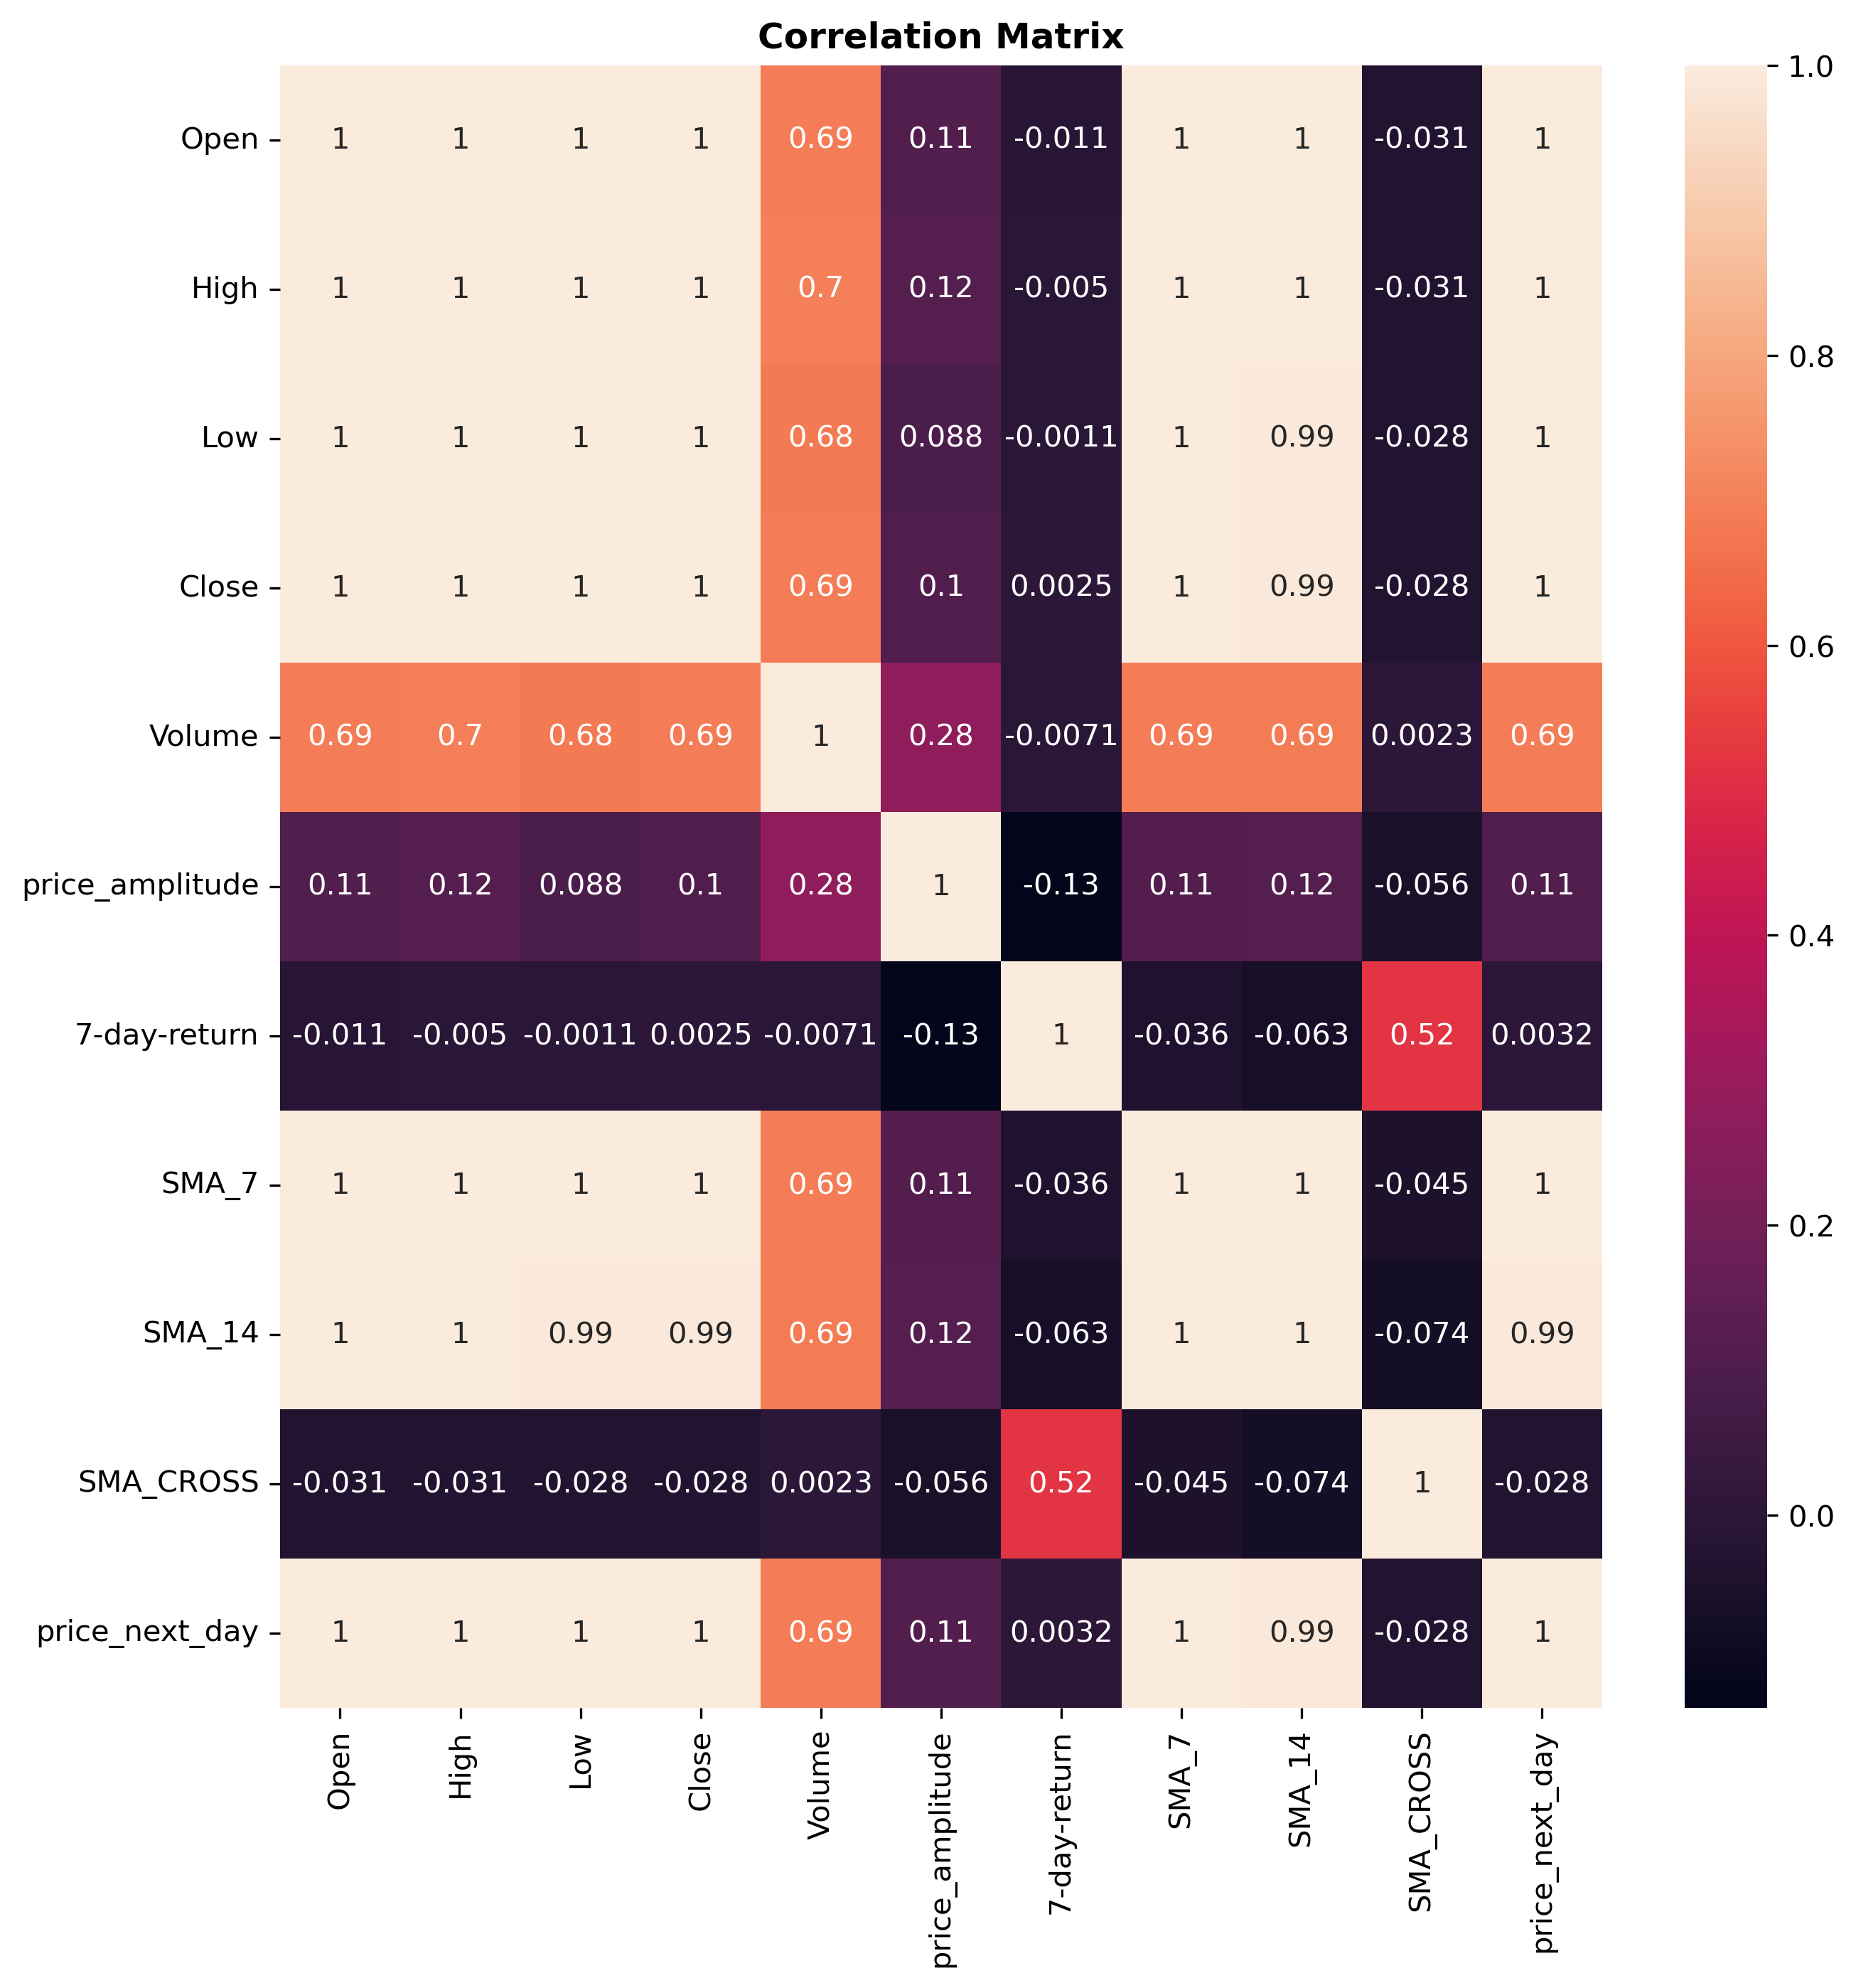

In [11]:
fig, ax = plt.subplots(figsize=[10, 10])
sns.heatmap(hist_bitcoin.corr(), annot=True)
plt.title("Correlation Matrix", fontweight="bold")
plt.show()

A priori, vamos a tener un problema con respecto a las variables. Como vemos, tenemos correlación lineal perfecta entre las variables "Open", "High", "Low", "Close", "SMA_7", "SMA_14" y el target "price_next_day". De hecho, no solo tienen correlación perfecta con el target, si no entre ellas también. Por tanto, sería conveniente eliminar algunas de ellas para no tener problemas de multicolinearidad.

Como SMA_7 y SMA_14 son las únicas que contienen información relativa al pasado, las dejaremos en primera instancia. El resto, excepto "Close" serán eliminadas:

In [12]:
hist_bitcoin.drop(columns=["Open", "High", "Low"], inplace=True)

El precio (Close) del día quedará como el principal marcador a la hora de predecir el precio (Close) del día siguiente: 

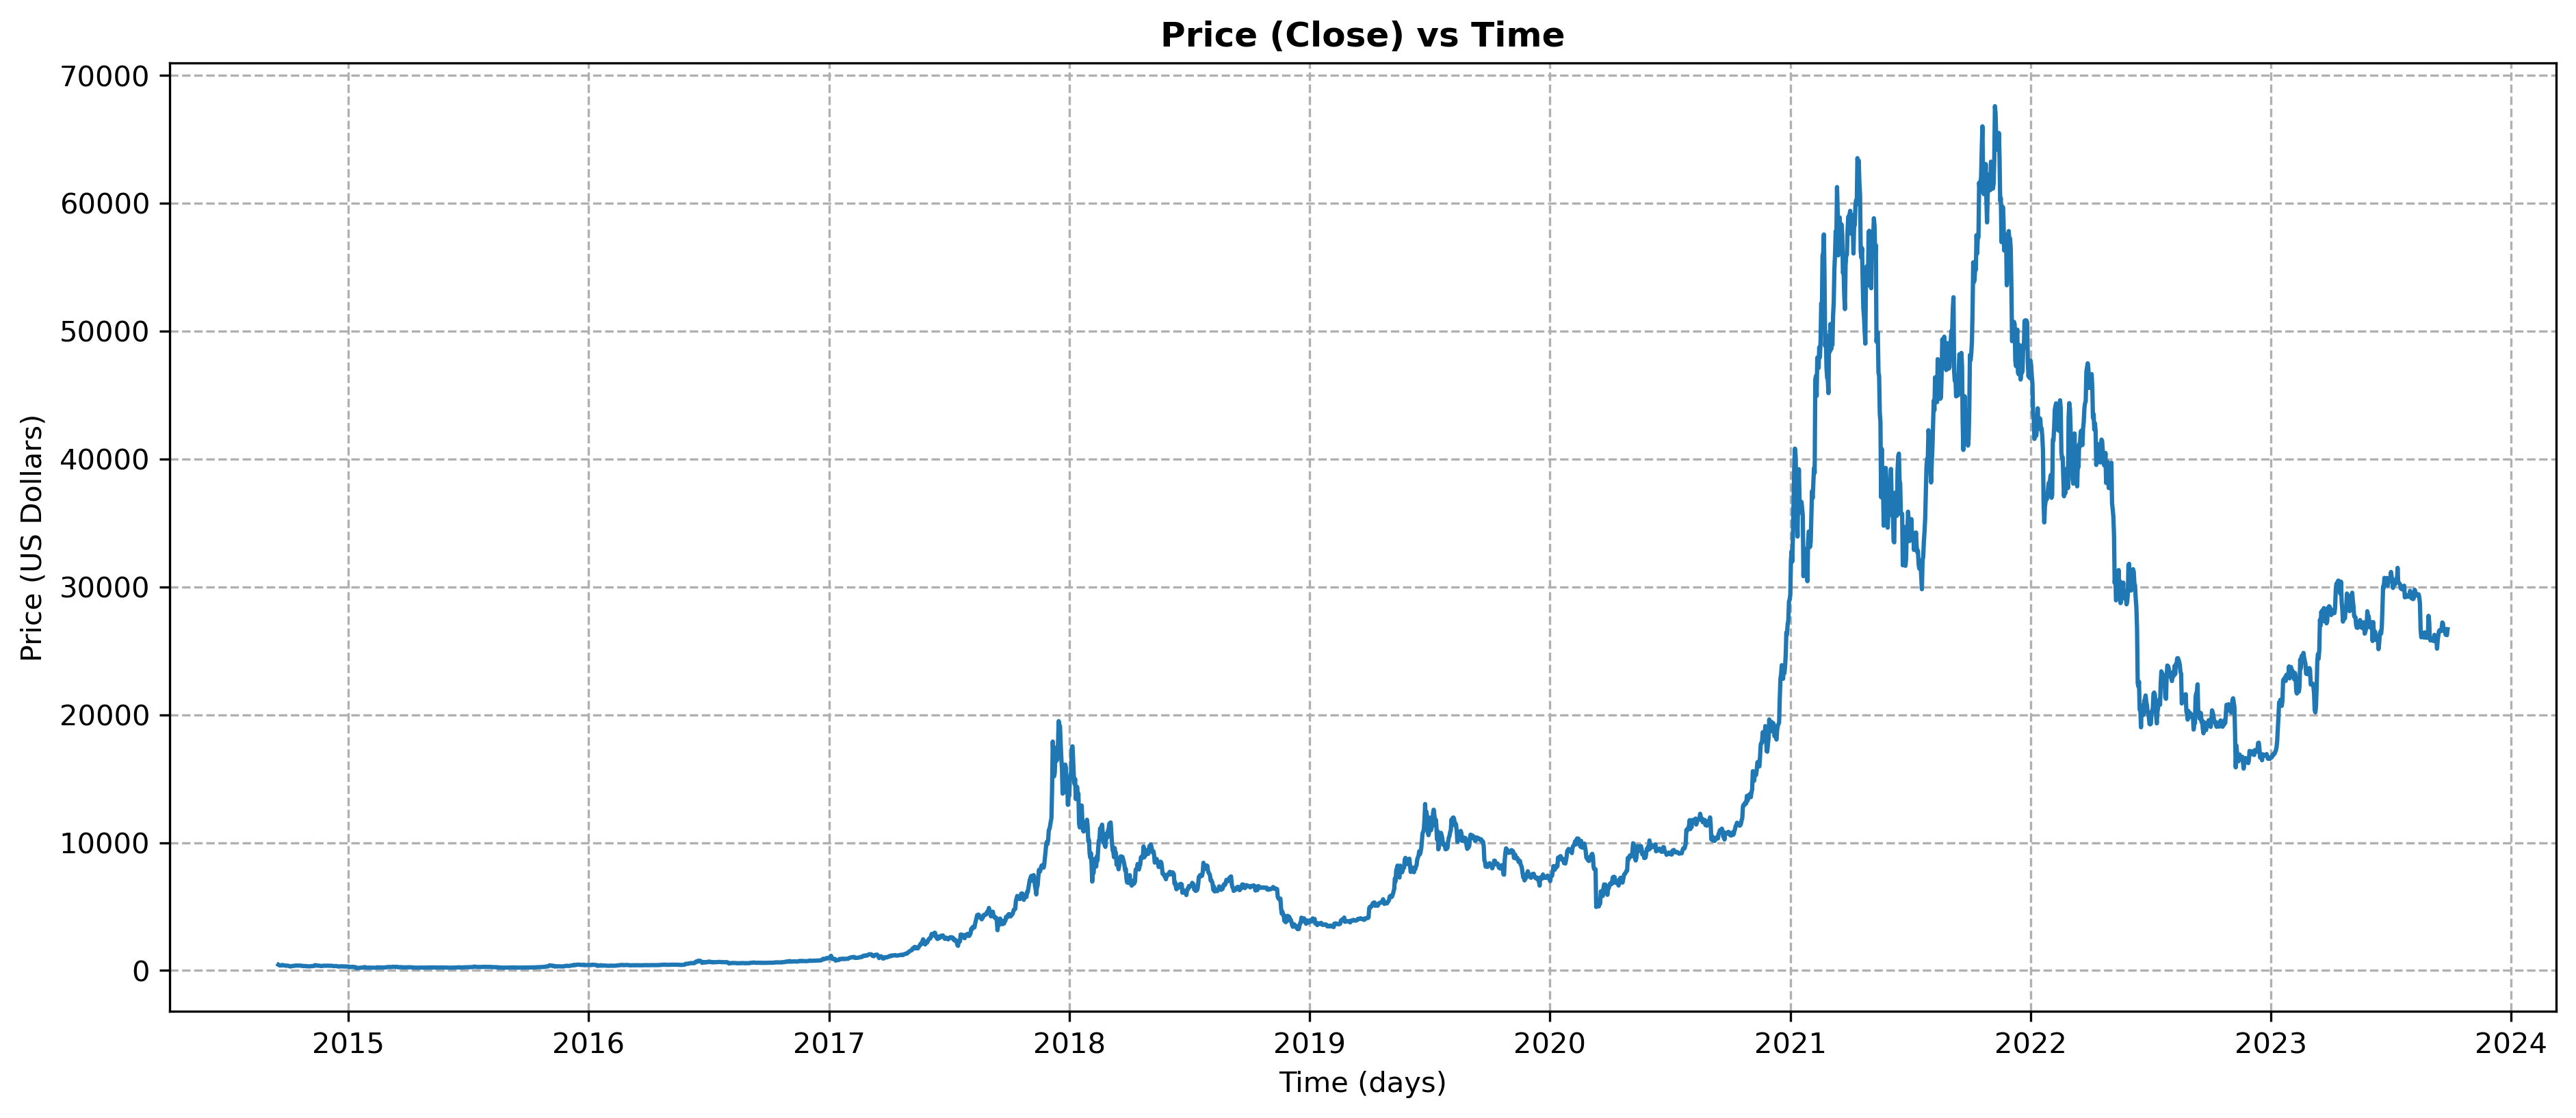

In [13]:
fig, ax = plt.subplots(figsize=[15,6])
ax.plot(hist_bitcoin["Close"])

plt.xlabel("Time (days)")
plt.ylabel("Price (US Dollars)")
plt.title("Price (Close) vs Time", fontweight="bold")
plt.grid(linestyle="dashed")
plt.show()

Una vez hecho esto, vamos a guardar el último día de nuestro dataset. Este es el que utilizaremos para la verdadera predicción del día siguiente y será eliminado del dataset, pues no se puede utilizar para train o test:

In [14]:
last_day = hist_bitcoin.drop(columns="price_next_day").iloc[[-1]]

Ahora sí, eliminamos los NaN:

In [15]:
hist_bitcoin.dropna(inplace=True)

Para finalizar la preparación de los datos previa al procesamiento de los mismos, vamos a eliminar unas cuantas filas del comienzo del dataframe. Esto es a causa de nuestro modelo de entrenamiento. Como utilizaremos ventanas de 500 puntos temporales con desplazamientos de 100 en 100, debemos tener un número múltiplo de 100. Por eso, eliminamos tantas filas al comienzo como sea el resto de la división entera de `len(hist_bitcoin)` con 100.

In [16]:
hist_bitcoin = hist_bitcoin[len(hist_bitcoin)%100:]

En este punto, estamos listos para escalar nuestros datos. Según indica la documentación de `SGDRegressor()` en `sklearn`, el modelo funciona mejor para puntos que tienen media nula y varianza igual a uno; es decir, para datos que provengan de una distribución normal. Por este motivo, vamos a estandarizar nuestros puntos usando `StandardScaler()`. Otra opción interesante hubiese podido ser escalar usando `MinMaxScaler()`, pues este respeta la forma previa de la distribución:

In [17]:
scaler = StandardScaler()

X = np.array(hist_bitcoin.drop(columns='price_next_day'))
X = scaler.fit_transform(X)

y = np.array(hist_bitcoin['price_next_day'])

Una cuestión de suma importancia es que, una vez entrenado el modelo con estos datos escalados, debemos usar exactamente el mismo escalador (sin volver a definirlo) si queremos añadir datos nuevos sin reentrenar el modelo.

Una vez dicho esto, procedemos el bucle de entrenamiento. Como hemos dicho al comienzo, vamos a usar el método "rolling windows"; es decir, en vez de alimentar al modelo con todos los puntos, le daremos, poco a poco ventanas temporales con un tamaño y desplazamiento fijos. Un esquema del entrenamiento es el siguiente:

<img src="https://images2.imgbox.com/71/ef/X91uYzbu_o.jpg" alt="drawing" width="400"/>

Otra cuestión importante será el uso del método `.partial_fit()` en el entrenamiento de nuestro modelo de regresión. Según indica la documentación de `SGDRegressor()`, el uso de `.fit()` está recomendado para realizar un entrenamiento general; es decir, cuando como datos de entrenamiento se utiliza todo el dataset (excepto los reservados a **test**, claro está). Por este motivo, `.fit()`, cuando es aplicado por segunda vez, descarta toda la información previa, impidiendo que el sistema se reentrene usando datos parciales. Todo esto se soluciona con el método `.partial_fit()`, al cuál se utiliza para reentrenar el modelo con nuevos datos conforme estos estén disponibles. Está recomendado para los entrenamientos de tipo **rolling forecast**; es decir, aquellos en los que los datos van llegando de forma temporal. 

In [18]:
SGD = SGDRegressor(shuffle=False)
y_pred_total = []
MAE = []
MSE = []
MAPE = []
for time_lag in range(0, len(X)-400, 100):
    X_train = X[time_lag:400+time_lag]
    y_train = y[time_lag:400+time_lag]
    X_test = X[400+time_lag:500+time_lag]
    y_test = y[400+time_lag:500+time_lag]
    
    SGD.partial_fit(X_train, y_train)

    try:
        y_pred = SGD.predict(X_test)

        y_pred_total.extend(y_pred)

        MAE.append(mean_absolute_error(y_test, y_pred))
        MSE.append(mean_squared_error(y_test, y_pred))
        MAPE.append(mean_absolute_percentage_error(y_test, y_pred))
    except:
        print("No hay más puntos para test")

Veamos cómo se ha comportado nuestro modelo en cuanto a los errores en las diferentes ventanas temporales de entrenamiento:

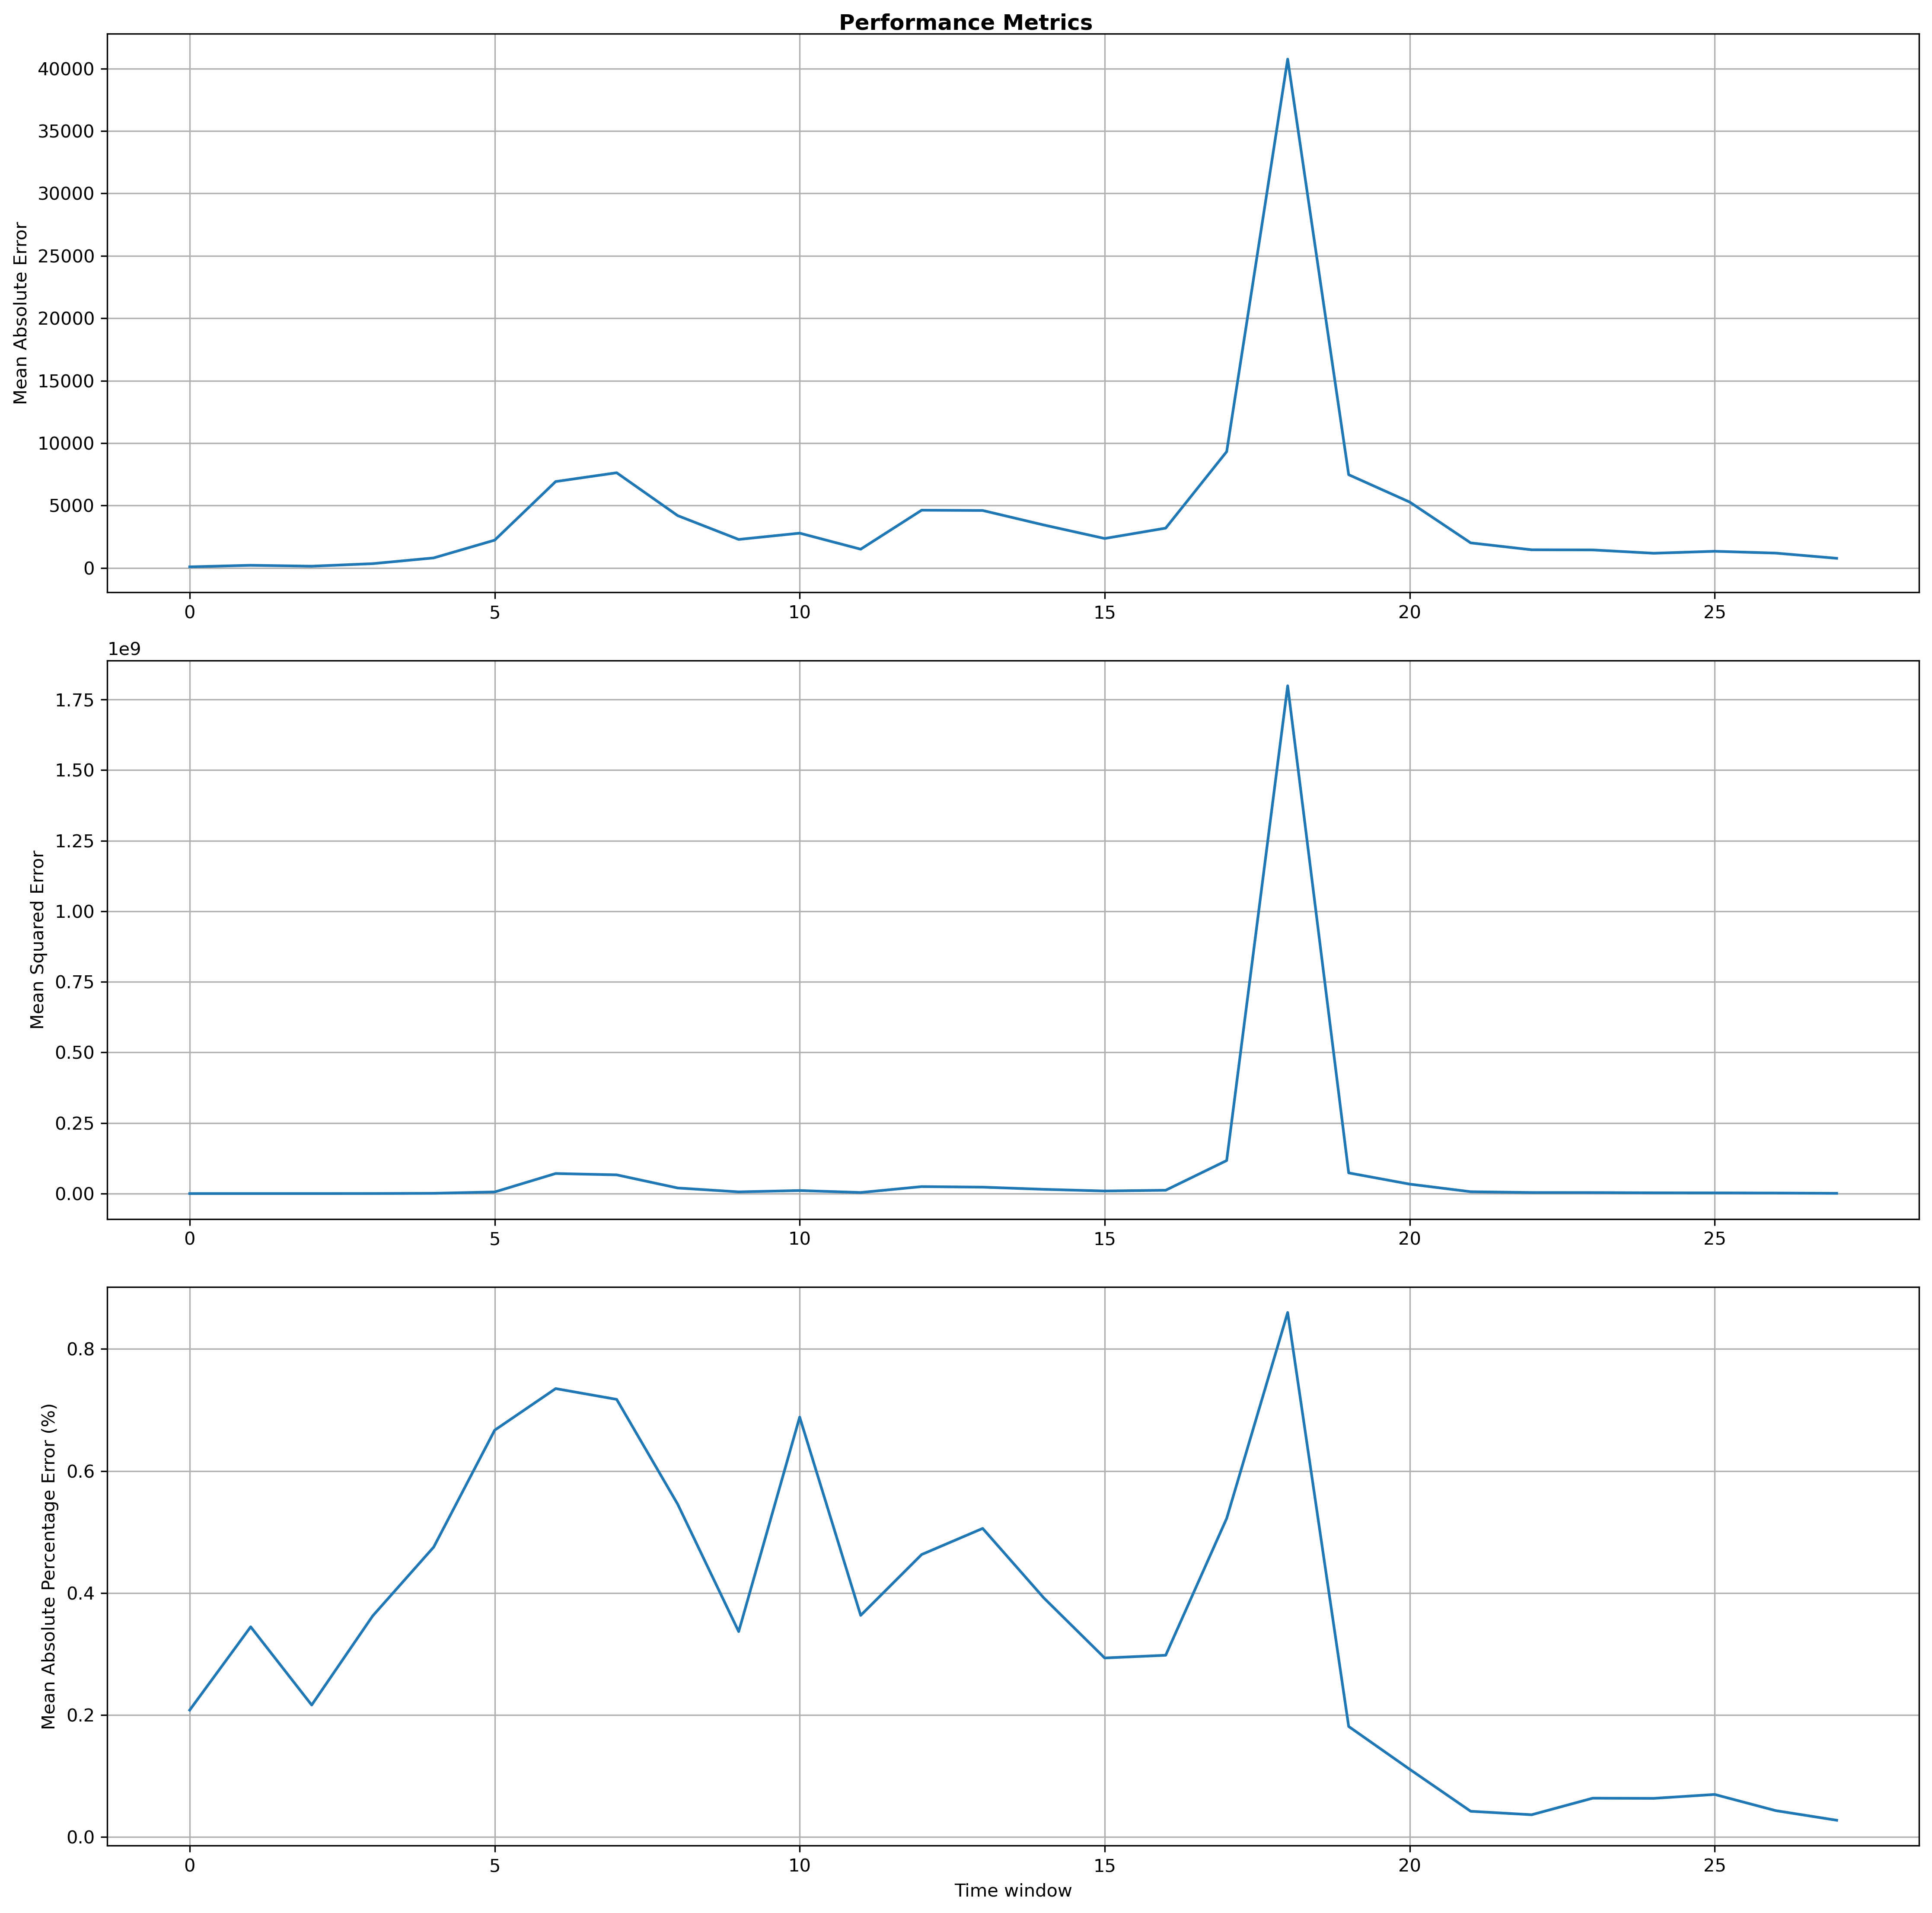

In [19]:
fig, ax = plt.subplots(3, 1, figsize=[15, 15])
plt.xlabel("Time window")

ax[0].plot(MAE)
ax[0].set_ylabel("Mean Absolute Error")
ax[0].grid()

ax[1].plot(MSE)
ax[1].set_ylabel("Mean Squared Error")
ax[1].grid()

ax[2].plot(MAPE)
ax[2].set_ylabel("Mean Absolute Percentage Error (%)")
ax[2].grid()

plt.suptitle("Performance Metrics", fontweight="bold")

plt.tight_layout()
plt.show()

Lo que vemos en las gráficas anteriores es que, conforme nuestro modelo aprende, el error poco a poco va disminuyendo. El notable la brusca subida, de nuevo, del error en la ventana temporal 18. Esto es debido a la brusca (e inesperada) subida que realiza el precio del Bitcoin a finales del año 2020 y comienzos del 2021. Tras esto, vemos que el modelo se estabiliza y comienza a ajustarse debidamente a la variable target.

A fina de poder comprobar, de forma gráfica, la diferencia entre la predicción y los valores reales del precio, vamos a introducir las predicciones dentro de nuestro dataframe. Como es lógico, debido a la forma de entrenamiento, los primeros 400 valores carecen de una predicción; por tanto, rellenamos éstos con valores NaN:

In [20]:
hist_bitcoin["price_next_day_pred"] = np.append(np.full(400, np.nan), y_pred_total)

Tras esto, podemos ver como queda la estructura de nuestro dataframe. De esta forma, tenemos "price_next_day" como el precio real y, a su derecha, "price_next_day_pred" como la predicción realizada por el modelo en los sucesivos test.

In [21]:
hist_bitcoin.tail()

,Close,Volume,price_amplitude,7-day-return,SMA_7,SMA_14,SMA_CROSS,price_next_day,price_next_day_pred
Date,,,,,,,,,
2023-09-22 00:00:00+00:00,26579.568359,10578746709,0.870128,-0.157999,26763.868025,26389.119280,1,26579.390625,25547.406852
2023-09-23 00:00:00+00:00,26579.390625,7404700301,0.428596,0.060313,26765.455078,26437.955915,1,26256.826172,25414.924718
2023-09-24 00:00:00+00:00,26256.826172,8192867686,1.887826,-1.515983,26725.832031,26468.284459,1,26298.480469,25001.181578
2023-09-25 00:00:00+00:00,26298.480469,11997833257,1.576378,-2.479033,26660.717634,26549.414900,1,26217.250000,25264.531546
2023-09-26 00:00:00+00:00,26217.250000,9985498161,1.146660,-5.367982,26518.736607,26576.836775,0,26682.441406,25294.356147


Gráficamente queda de la forma:

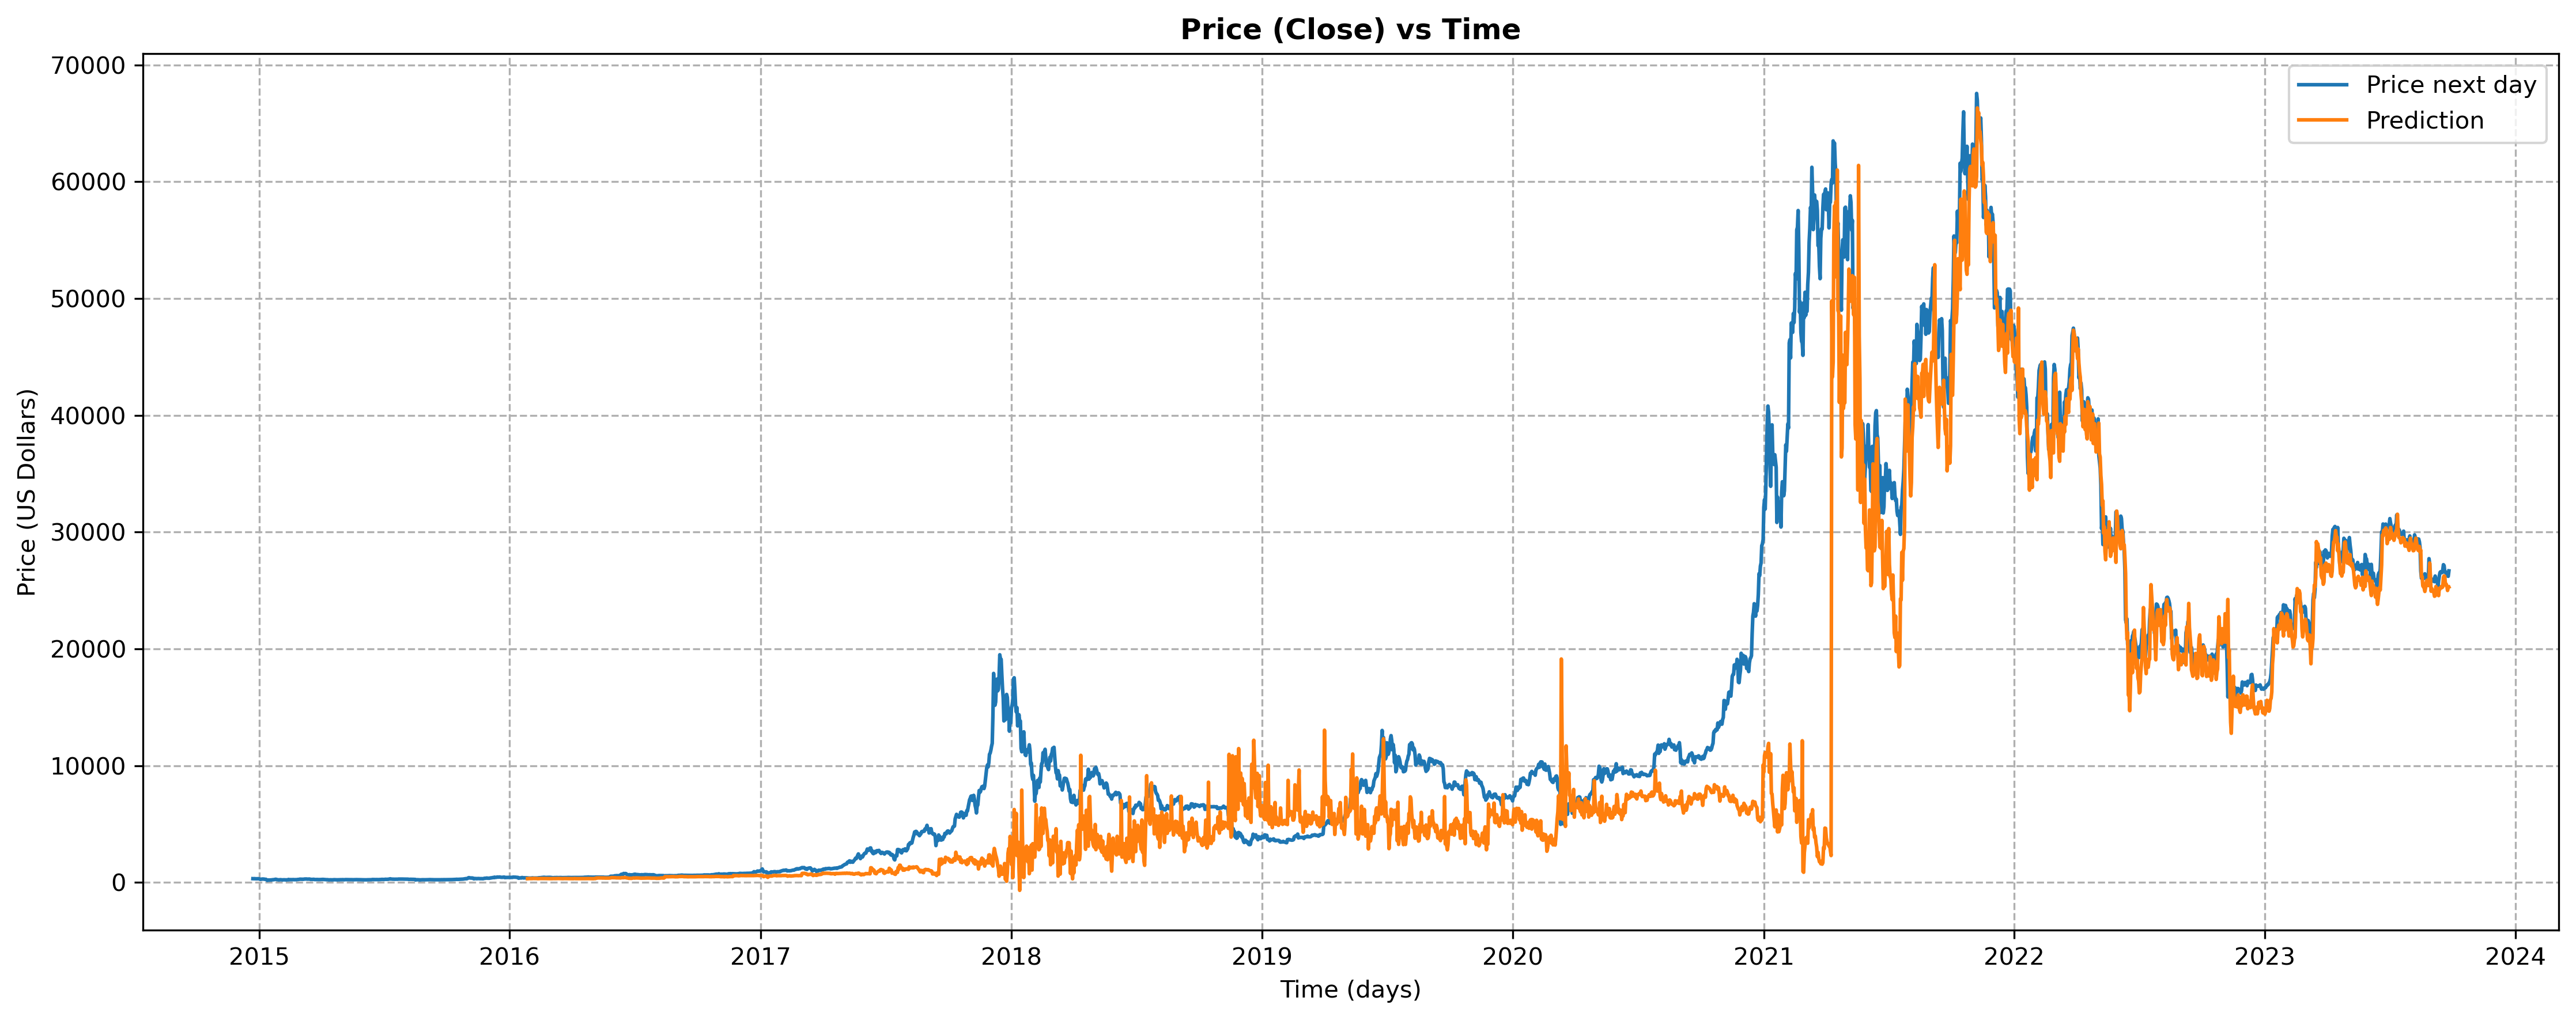

In [22]:
fig, ax = plt.subplots(figsize=[15,6])
ax.plot(hist_bitcoin["price_next_day"], label="Price next day")
ax.plot(hist_bitcoin["price_next_day_pred"], label="Prediction")

plt.xlabel("Time (days)")
plt.ylabel("Price (US Dollars)")
plt.title("Price (Close) vs Time", fontweight="bold")
plt.grid(linestyle="dashed")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Hecho esto, tan solo queda realizar la predicción del día siguiente para hoy y, con suerte, esperar que acierte para hacernos ricos :)

Lo primero es escalar el día de hoy usando el **mismo** escalador que usamos para entrenar:

In [23]:
last_day_scale = scaler.transform(np.array(last_day))

Y pedir nuestra predicción:

In [24]:
price_tomorrow = SGD.predict(last_day_scale)[0]
print(f"The price for tomorrow is: ${price_tomorrow}")

The price for tomorrow is: $25511.987776173737


### Extra: Predicción usando una red neuronal

Como arquitectura de la red neuronal se ha usado una relativamente estándar dentro del "time series forecasting". Esta consta de 4 capas:
- Una capa LSTM con 100 unidades de red. Configura `return_sequence` como `True` para que la salida de la capa sea otra secuencia de la misma longitud.
- Otra capa LSTM, también 100 unidades de red. Pero esta vez, configura `return_sequence` como `False` para que solo devuelva la última salida en la secuencia.
- Una capa de red neuronal densamente conectada con 30 unidades de red.
- Una capa densamente conectada que especifica la salida de 1 unidad de red, correspondiente a la predicción del precio del día siguiente.

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)),
    tf.keras.layers.LSTM(100, return_sequences=False),
    tf.keras.layers.Dense(30, activation='relu'),  
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 30)                3030      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 124,261
Trainable params: 124,261
Non-trainable params: 0
_________________________________________________________________


Como optimizador, usaremos `Adam` pues es otro de los estándares para este tipo de problemas. Se ha ajustado `learning_rate` a su valor por defecto de 0.001; sin embargo, se ha hecho de forma explícita para poder cambiarlo con más facilidad en las pruebas. Como función de pérdida se usa el error de mínimos cuadrados.

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

A partir de aquí, se ha realizado, usando la red neuronal, el mismo principio de entrenamiento con ventanas temporales. Se ha configurado la parada temprana (early stoping) para cortar de forma prematura el entrenamiento si el valor de la función de pérdida comienza a aumentar en el transcurso del mismo.

De igual forma, se ha utilizado un 20% del total de los valores de entrenamiento como set de validación. En todo momento se ha establecido el parámetro `shufle=False`, a fin de que el orden de los datos no se vea alterado.

In [27]:
# Hyperparameters
batch_size = 1
epochs = 10

# Training and evaluation
y_pred_total_rnn = []
MAE = []
MSE = []
MAPE = []

for time_lag in range(0, len(X) - 400, 100):
    X_train = X[time_lag:400+time_lag]
    y_train = y[time_lag:400+time_lag]
    X_test = X[400+time_lag:500+time_lag]
    y_test = y[400+time_lag:500+time_lag]

    # Train the model with early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,  # Use a validation set
        shuffle=False,  # Shuffle data if needed
        callbacks=[early_stopping]
    )

    # Predict on the test window
    y_pred = model.predict(X_test)

    y_pred_total_rnn.extend(y_pred)

    MAE.append(mean_absolute_error(y_test, y_pred))
    MSE.append(mean_squared_error(y_test, y_pred))
    MAPE.append(mean_absolute_percentage_error(y_test, y_pred))

Epoch 1/10
320/320 [==============================] - 7s 9ms/step - loss: 28329.9004 - val_loss: 31322.4844
Epoch 2/10
320/320 [==============================] - 2s 5ms/step - loss: 1230.8369 - val_loss: 21167.0664
Epoch 3/10
320/320 [==============================] - 1s 5ms/step - loss: 1232.0892 - val_loss: 20667.2344
Epoch 4/10
320/320 [==============================] - 1s 5ms/step - loss: 1247.1570 - val_loss: 20307.9961
Epoch 5/10
320/320 [==============================] - 1s 5ms/step - loss: 1256.3931 - val_loss: 20042.8711
Epoch 6/10
320/320 [==============================] - 2s 5ms/step - loss: 1262.3370 - val_loss: 19847.8867
Epoch 7/10
320/320 [==============================] - 2s 5ms/step - loss: 1266.2686 - val_loss: 19705.5879
Epoch 8/10
320/320 [==============================] - 2s 5ms/step - loss: 1268.9180 - val_loss: 19602.6230
Epoch 9/10
320/320 [==============================] - 2s 5ms/step - loss: 1270.7263 - val_loss: 19528.7871
Epoch 10/10
4/4 [===================

Veamos cómo se ha comportado nuestro modelo en cuanto a los errores en las diferentes ventanas temporales de entrenamiento:

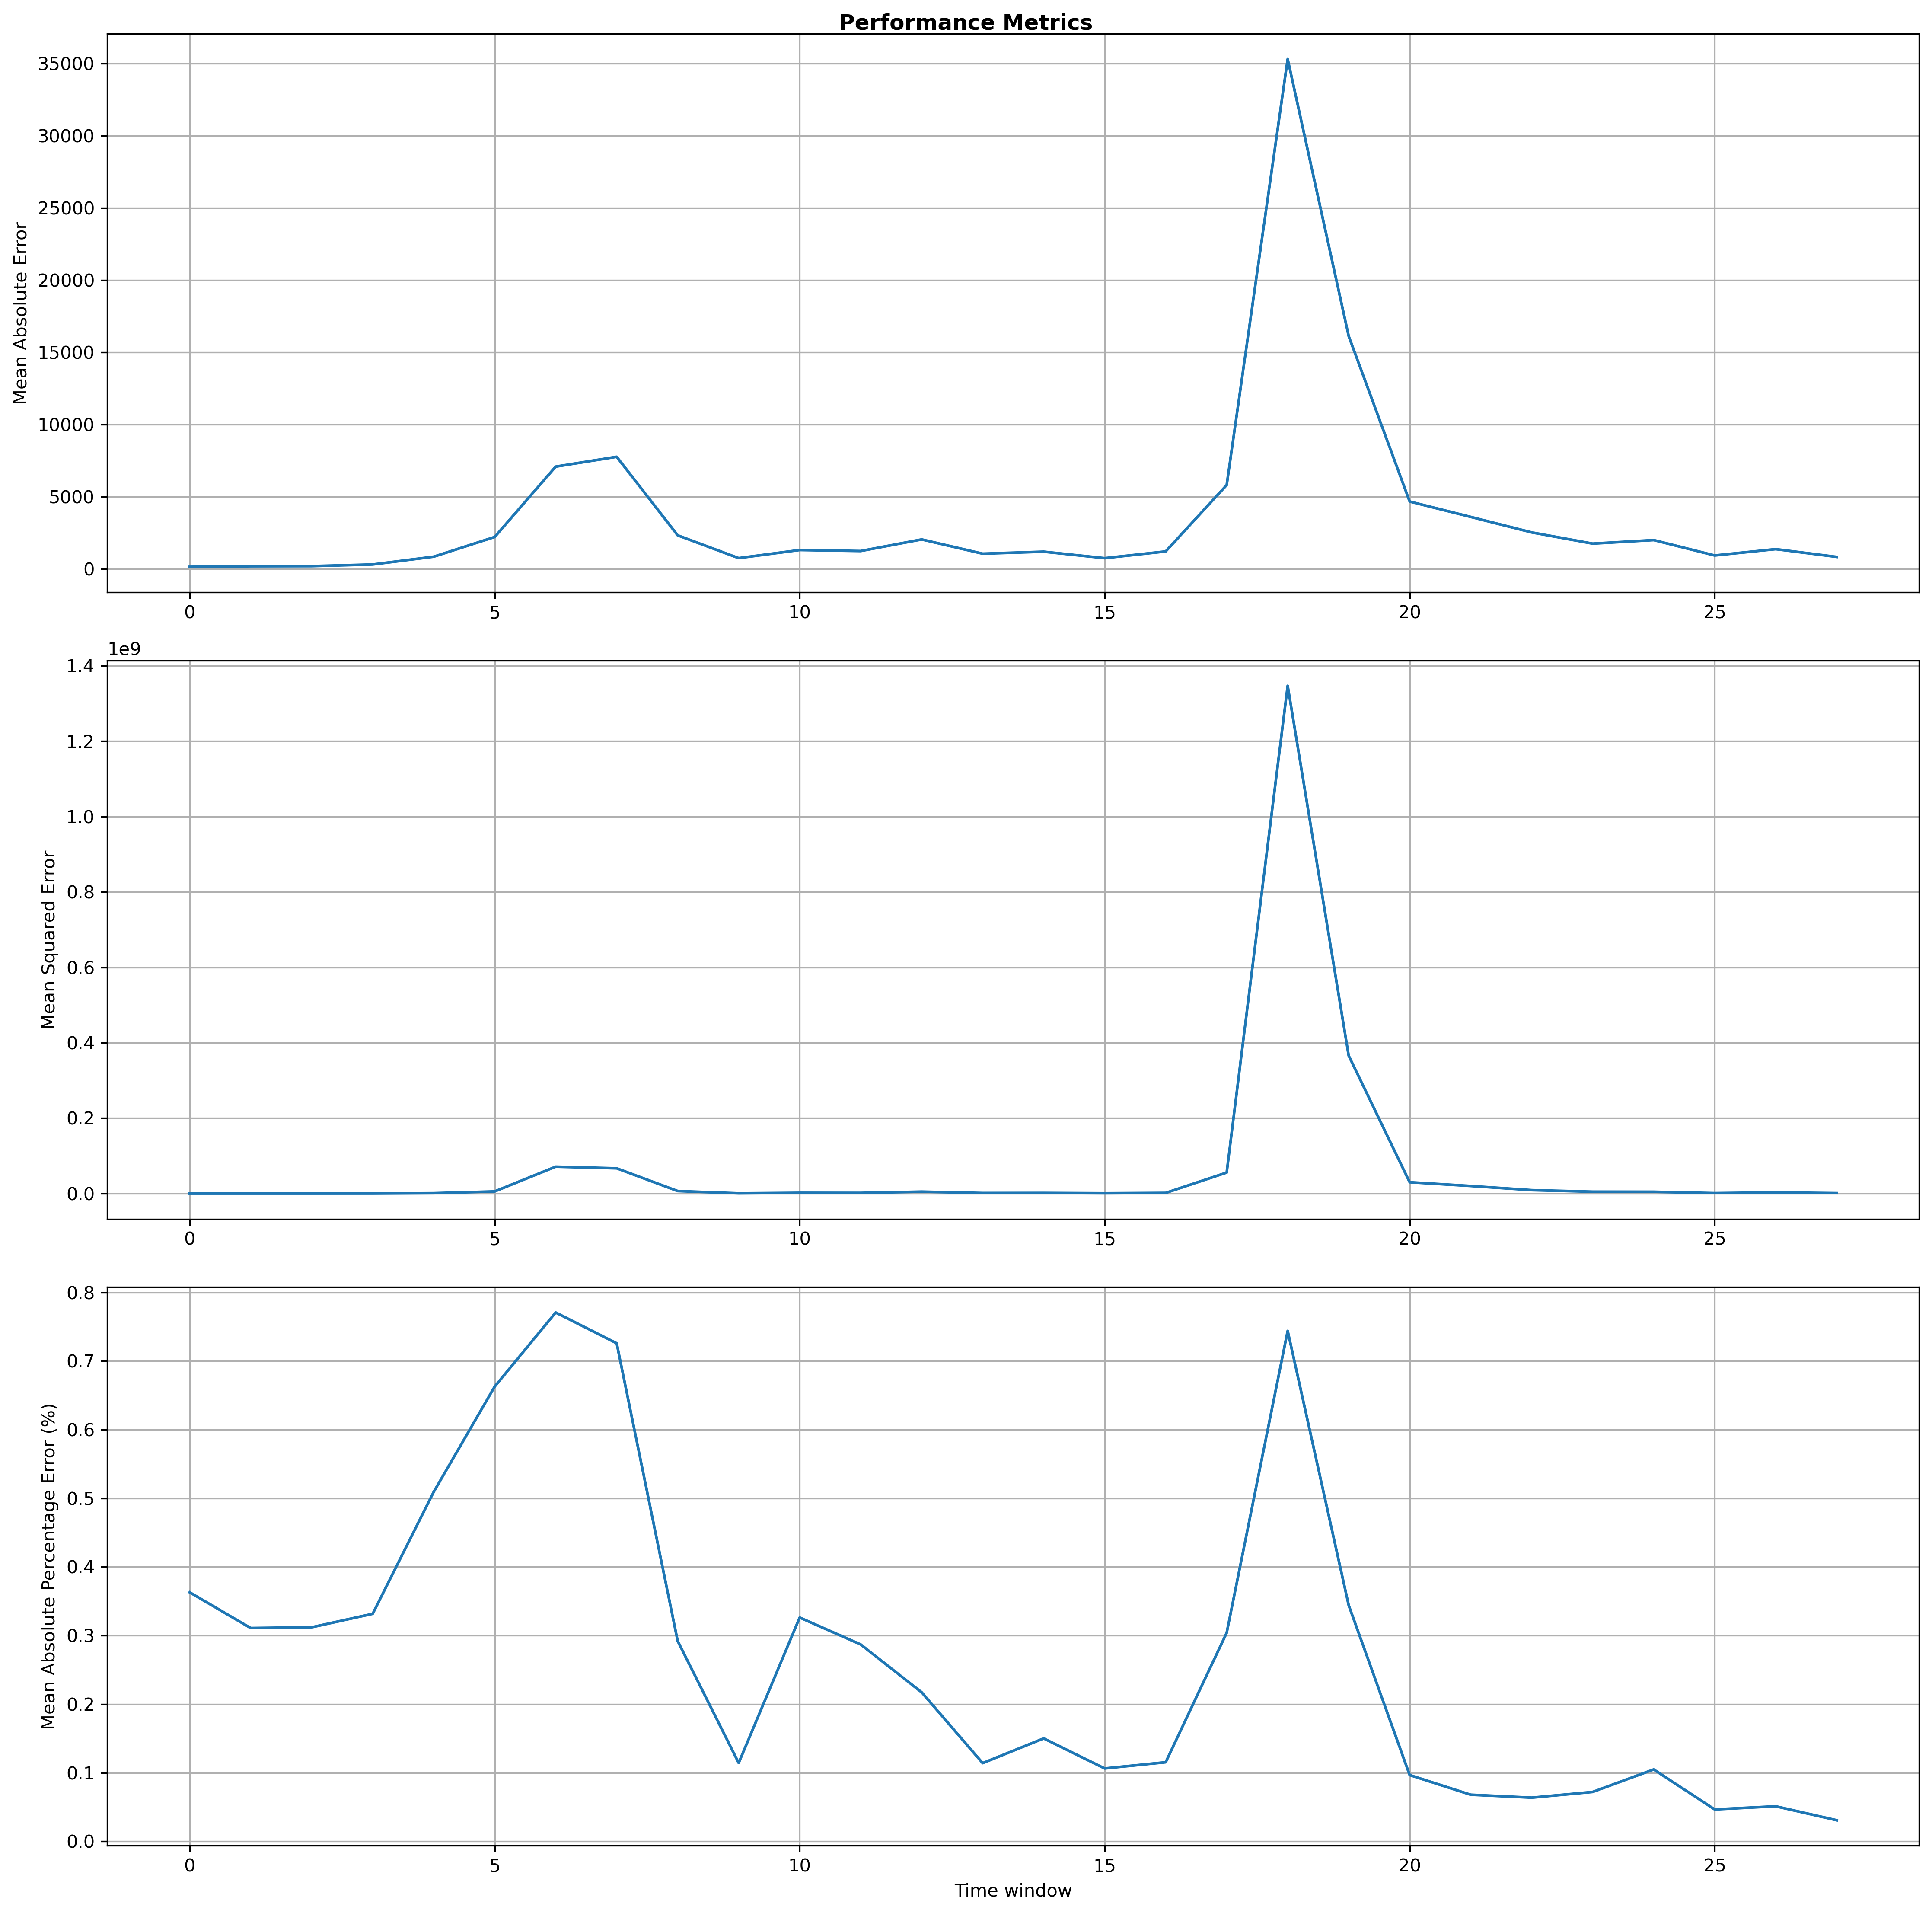

In [34]:
fig, ax = plt.subplots(3, 1, figsize=[15, 15])
plt.xlabel("Time window")

ax[0].plot(MAE)
ax[0].set_ylabel("Mean Absolute Error")
ax[0].grid()

ax[1].plot(MSE)
ax[1].set_ylabel("Mean Squared Error")
ax[1].grid()

ax[2].plot(MAPE)
ax[2].set_ylabel("Mean Absolute Percentage Error (%)")
ax[2].grid()

plt.suptitle("Performance Metrics", fontweight="bold")

plt.tight_layout()
plt.show()

Añadimos, al igual que hicimos con las predicciones del modelo de regresión lineal, los valores predichos por la red neuronal a nuestro datraframe de precios del bitcoin:

In [35]:
hist_bitcoin["price_next_day_pred_RNN"] = np.append(np.full(400, np.nan), y_pred_total_rnn)

In [36]:
hist_bitcoin.tail()

,Close,Volume,price_amplitude,7-day-return,SMA_7,SMA_14,SMA_CROSS,price_next_day,price_next_day_pred,price_next_day_pred_RNN
Date,,,,,,,,,,
2023-09-22 00:00:00+00:00,26579.568359,10578746709,0.870128,-0.157999,26763.868025,26389.119280,1,26579.390625,25547.406852,28018.988281
2023-09-23 00:00:00+00:00,26579.390625,7404700301,0.428596,0.060313,26765.455078,26437.955915,1,26256.826172,25414.924718,28076.935547
2023-09-24 00:00:00+00:00,26256.826172,8192867686,1.887826,-1.515983,26725.832031,26468.284459,1,26298.480469,25001.181578,27594.410156
2023-09-25 00:00:00+00:00,26298.480469,11997833257,1.576378,-2.479033,26660.717634,26549.414900,1,26217.250000,25264.531546,27497.230469
2023-09-26 00:00:00+00:00,26217.250000,9985498161,1.146660,-5.367982,26518.736607,26576.836775,0,26682.441406,25294.356147,26443.966797


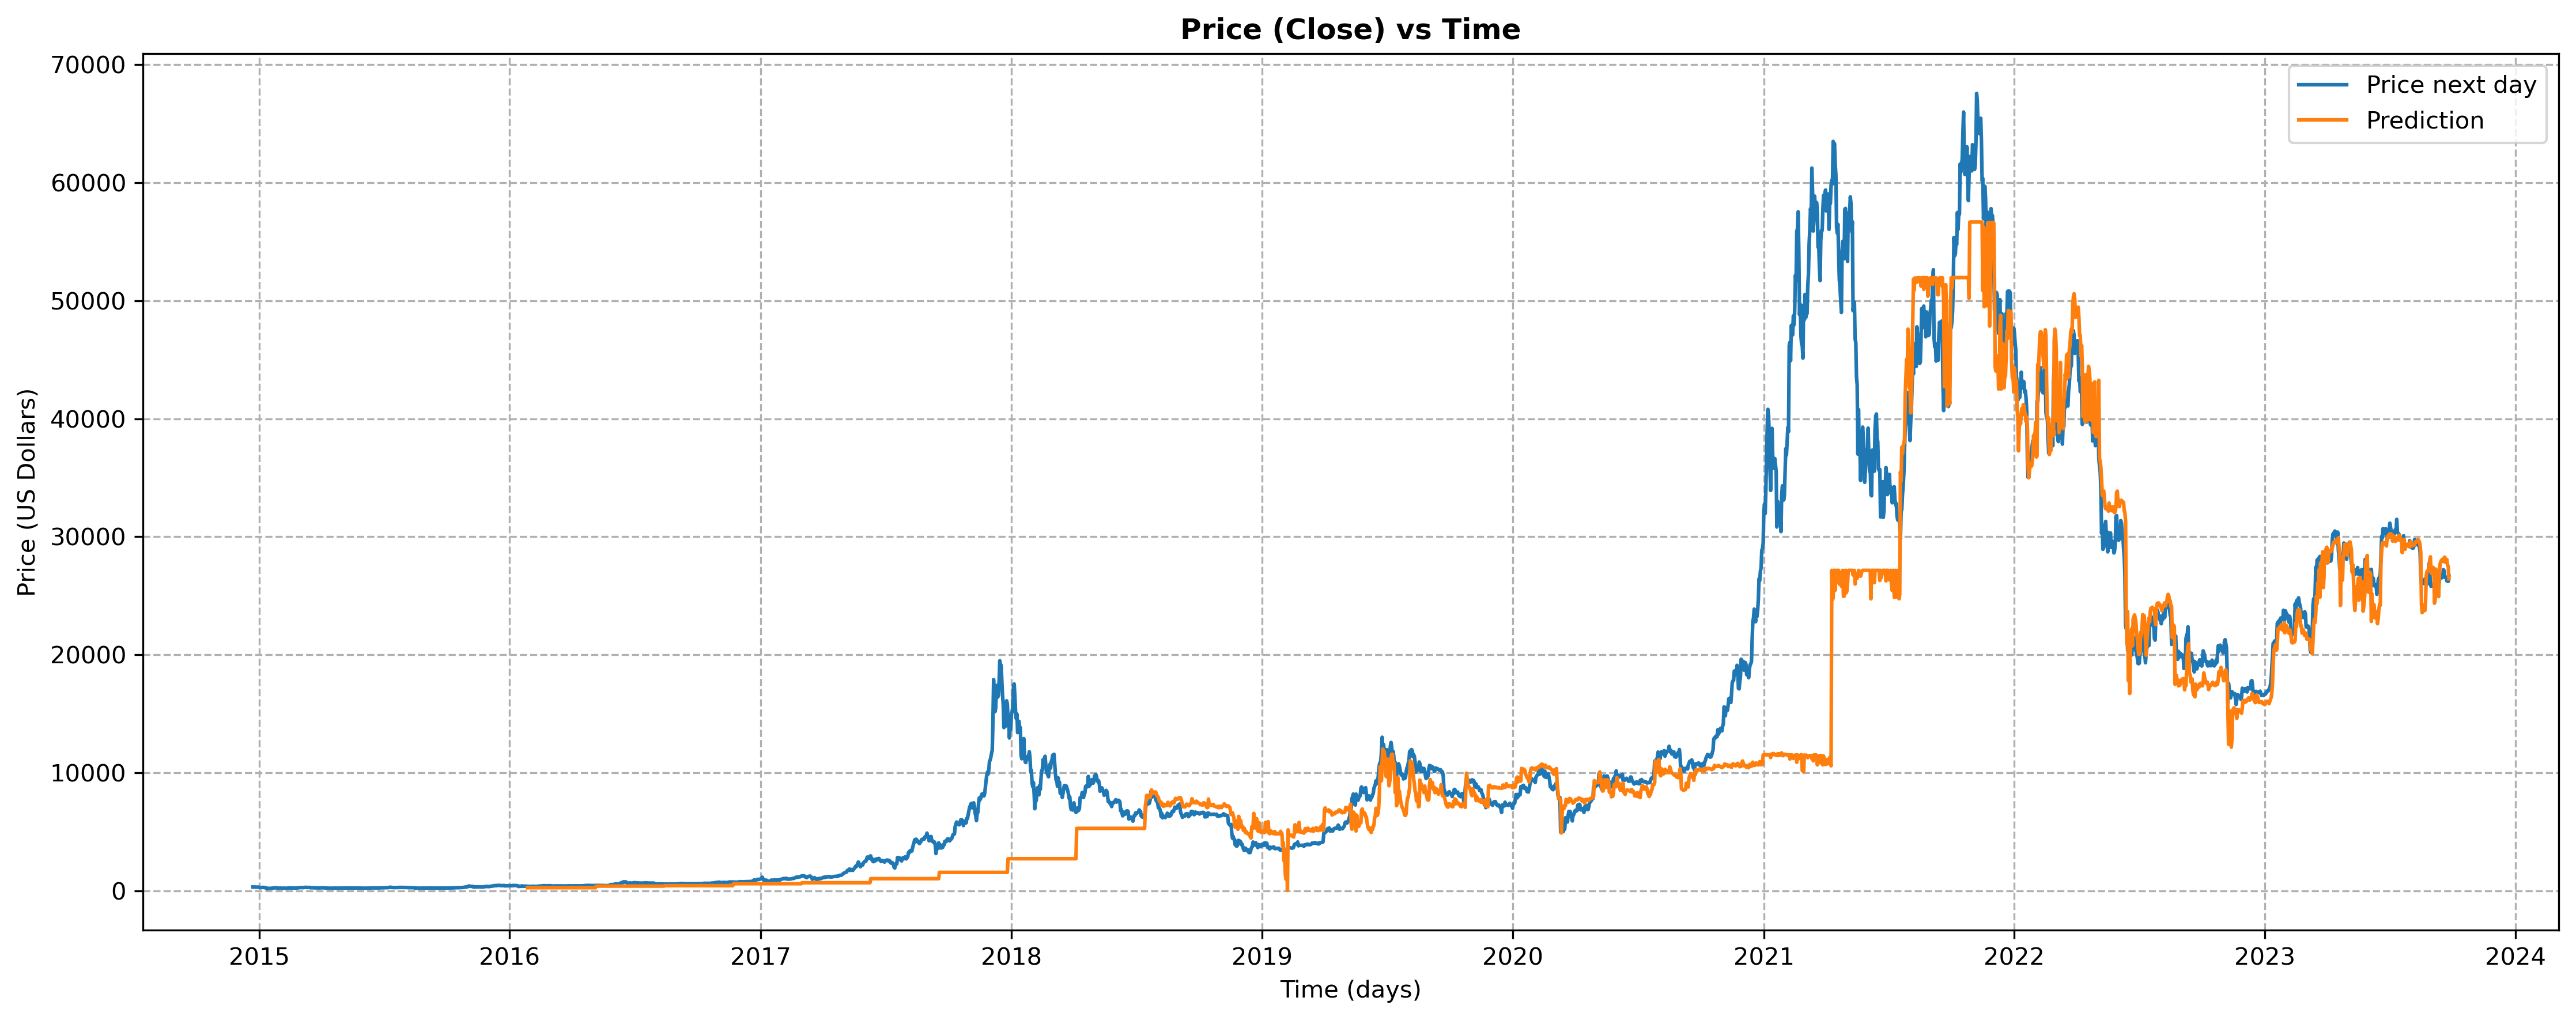

In [37]:
fig, ax = plt.subplots(figsize=[15,6])
ax.plot(hist_bitcoin["price_next_day"], label="Price next day")
ax.plot(hist_bitcoin["price_next_day_pred_RNN"], label="Prediction")

plt.xlabel("Time (days)")
plt.ylabel("Price (US Dollars)")
plt.title("Price (Close) vs Time", fontweight="bold")
plt.grid(linestyle="dashed")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [39]:
price_tomorrow = model.predict(last_day_scale)[0][0]
print(f"The price for tomorrow is: ${price_tomorrow}")

1/1 [==============================] - 0s 29ms/step
The price for tomorrow is: $27575.970703125


In [33]:
#model.save('Bitcoin_prediction.h5')